# Forecasting casos leves de COVID-19

In [82]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from epiweeks import Week

# Estatísticas
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Dados

In [2]:
df = pd.read_csv('../data/processed/dados.csv', delimiter = ';')

In [3]:
df.head()

,Unnamed: 0,id,dataInicioSintomas,dataNotificacao,dataAtualizacao,dataEncerramento,dataRegistro,regiao,estadoIBGE,idade
0,1,uVOUpcAwja,2023-11-25,2023-11-27,2023-12-12,2023-12-12,2023-11-27,1,12,25.0
1,2,Cg7XavXuQq,2023-12-01,2023-12-05,2023-12-12,2023-12-11,2023-12-07,1,13,26.0
2,3,bF7E1KySnh,2023-12-09,2023-12-12,2023-12-14,2023-12-14,2023-12-14,1,12,22.0
3,4,A8sEjw9taT,2023-11-21,2023-11-27,2023-12-18,NaN,2023-12-18,1,13,24.0
4,5,CfqY4VBedF,2023-12-11,2023-12-12,2023-12-18,2023-12-18,2023-12-18,1,12,24.0


# Tratamento de dados

In [4]:
df.shape

(2704725, 10)

In [5]:
df1 = df[[
    'dataInicioSintomas',
    'dataNotificacao',
    'dataAtualizacao',
    'dataEncerramento',
    'dataRegistro',
    'regiao',
    'estadoIBGE',
    'idade'
]]

df1.head()

,dataInicioSintomas,dataNotificacao,dataAtualizacao,dataEncerramento,dataRegistro,regiao,estadoIBGE,idade
0,2023-11-25,2023-11-27,2023-12-12,2023-12-12,2023-11-27,1,12,25.0
1,2023-12-01,2023-12-05,2023-12-12,2023-12-11,2023-12-07,1,13,26.0
2,2023-12-09,2023-12-12,2023-12-14,2023-12-14,2023-12-14,1,12,22.0
3,2023-11-21,2023-11-27,2023-12-18,NaN,2023-12-18,1,13,24.0
4,2023-12-11,2023-12-12,2023-12-18,2023-12-18,2023-12-18,1,12,24.0


In [6]:
print(df1.isna().sum())

dataInicioSintomas          0
dataNotificacao             0
dataAtualizacao             0
dataEncerramento      1130459
dataRegistro                0
regiao                      0
estadoIBGE                  0
idade                    2226
dtype: int64


## Criar série temporal por semana epidemiológica

In [100]:
# Converter para datetime
df['dataInicioSintomas'] = pd.to_datetime(df['dataInicioSintomas'])

# Calcular semana epidemiológica e ano epidemiológico
df['semana_epi'] = df['dataInicioSintomas'].apply(lambda x: Week.fromdate(x).week)
df['ano_epi'] = df['dataInicioSintomas'].apply(lambda x: Week.fromdate(x).year)

# Criar coluna dt_event com a data correspondente ao último dia da semana (domingo)
df['dt_event'] = df.apply(lambda row: Week(row['ano_epi'], row['semana_epi']).enddate(), axis=1)

# Criar uma coluna com o número da semana epidemiológica
df['num_semana_epi'] = df['semana_epi']

# Agrupar por dt_event e contar ocorrências
serie_semana = df.groupby(['dt_event', 'num_semana_epi']).size().reset_index(name='count')

# Mostrar a série temporal semanal com a coluna de semana epidemiológica
print(serie_semana)

       dt_event  num_semana_epi   count
0    2023-01-07               1  103376
1    2023-01-14               2   64015
2    2023-01-21               3   45188
3    2023-01-28               4   37199
4    2023-02-04               5   35865
..          ...             ...     ...
99   2024-11-30              48   13603
100  2024-12-07              49   16290
101  2024-12-14              50   14014
102  2024-12-21              51    6288
103  2024-12-28              52       3

[104 rows x 3 columns]


In [101]:
serie_semana.dtypes

dt_event          object
num_semana_epi     int64
count              int64
dtype: object

In [102]:
# Excluir observação final por estar com um número muito reduzido de casos
serie_semana_analise = serie_semana.drop(index=103)

print(serie_semana_analise)

       dt_event  num_semana_epi   count
0    2023-01-07               1  103376
1    2023-01-14               2   64015
2    2023-01-21               3   45188
3    2023-01-28               4   37199
4    2023-02-04               5   35865
..          ...             ...     ...
98   2024-11-23              47   10259
99   2024-11-30              48   13603
100  2024-12-07              49   16290
101  2024-12-14              50   14014
102  2024-12-21              51    6288

[103 rows x 3 columns]


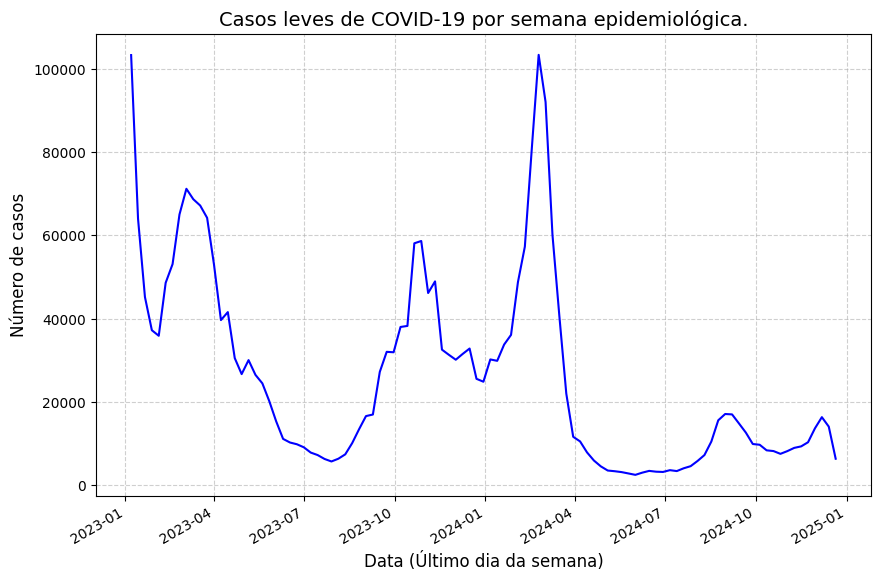

In [103]:
# Visualização dos dados
plt.figure(figsize=(10, 6))
plt.plot(serie_semana_analise['dt_event'], serie_semana_analise['count'], color='b')

plt.title('Casos leves de COVID-19 por semana epidemiológica.', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xlabel('Data (Último dia da semana)', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)

plt.show()

# Análise exploratória da ST

### Estacionariedade
Após diferenciação de primeira ordem os dados apresentaram comportamento estacionário.

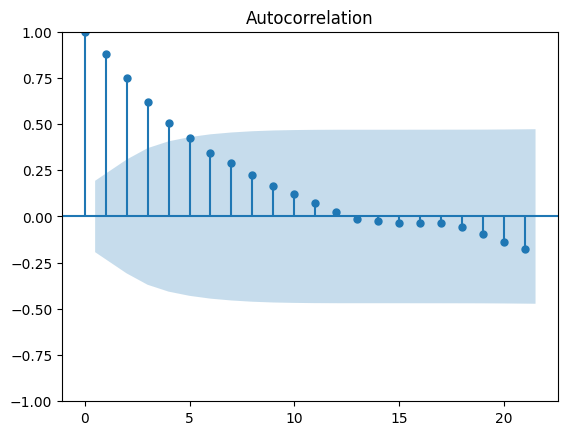

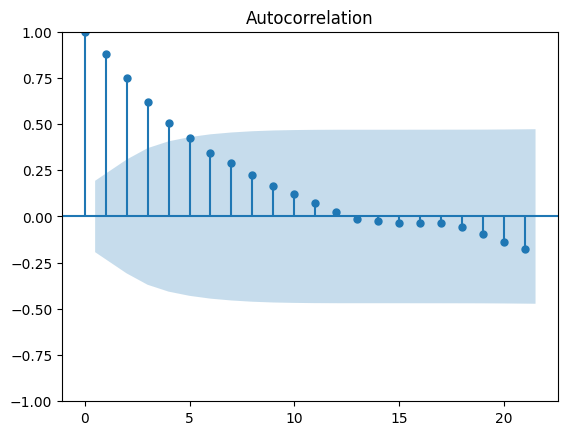

In [104]:
# Autocorrelação
plot_acf(serie_semana_analise['count'])

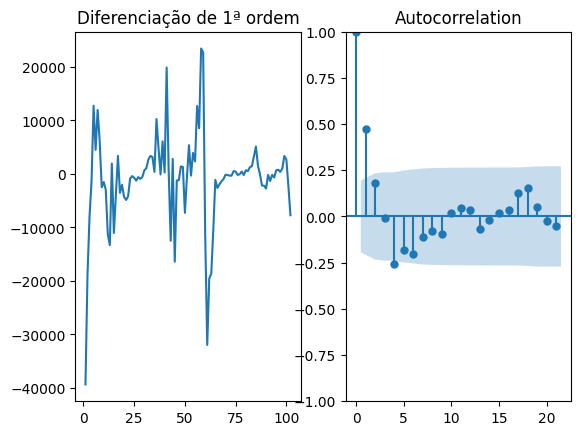

In [105]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 1ª ordem')
ax1.plot(serie_semana_analise['count'].diff())

ax2 = f.add_subplot(122)
plot_acf(serie_semana_analise['count'].diff().dropna(), ax=ax2)
plt.show()

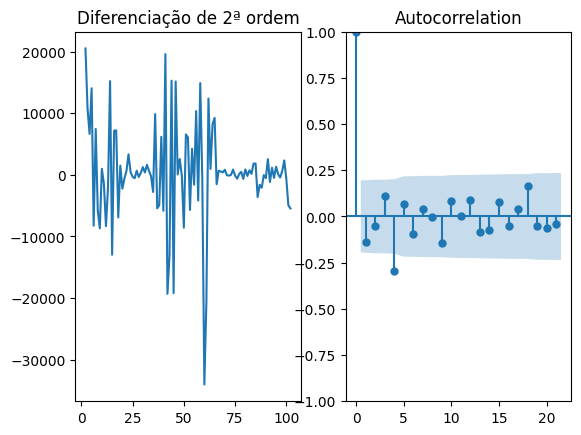

In [106]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 2ª ordem')
ax1.plot(serie_semana_analise['count'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(serie_semana_analise['count'].diff().diff().dropna(), ax=ax2)
plt.show()

In [107]:
# Teste Dickey-Fuller para raiz unitária
result = adfuller(serie_semana_analise['count'].dropna())
print('p-valor: ', result[1])

result = adfuller(serie_semana_analise['count'].diff().dropna())
print('p-valor: ', result[1])

result = adfuller(serie_semana_analise['count'].diff().diff().dropna())
print('p-valor: ', result[1])

p-valor:  0.06721162494254816
p-valor:  4.4935815858051956e-08
p-valor:  1.8711584270320488e-06


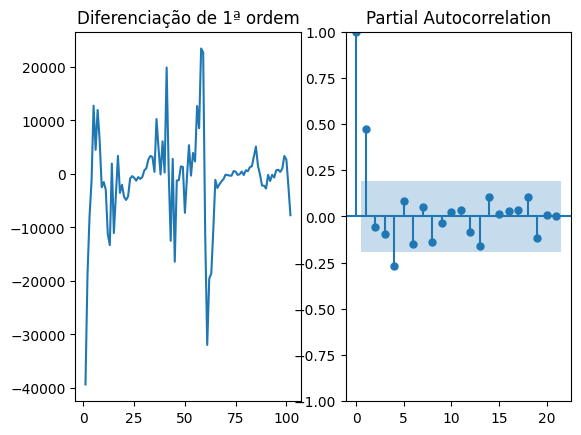

In [108]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 1ª ordem')
ax1.plot(serie_semana_analise['count'].diff())

ax2 = f.add_subplot(122)
plot_pacf(serie_semana_analise['count'].diff().dropna(), ax=ax2)
plt.show()

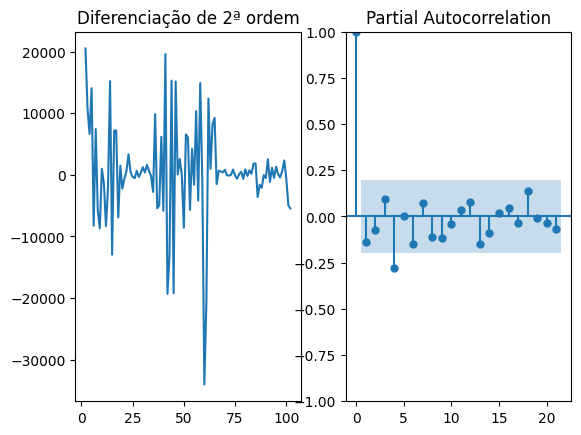

In [109]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('Diferenciação de 2ª ordem')
ax1.plot(serie_semana_analise['count'].diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(serie_semana_analise['count'].diff().diff().dropna(), ax=ax2)
plt.show()

In [110]:
# Modelo ARIMA
# Converter a coluna de datas para o formato datetime e definir como índice
serie_semana_analise['dt_event'] = pd.to_datetime(serie_semana_analise['dt_event'])
serie_semana_analise.set_index('dt_event', inplace=True)

In [127]:
# Criar e ajustar o modelo ARIMA
arima_model = ARIMA(serie_semana_analise['count'], order=(2, 1, 1))  # Configurar o modelo ARIMA com ordem (p,d,q)
model = arima_model.fit()

# Exibir o resumo do modelo
print(model.summary())

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible sta

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  103
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1064.698
Date:                Thu, 02 Jan 2025   AIC                           2137.396
Time:                        17:18:36   BIC                           2147.896
Sample:                    01-07-2023   HQIC                          2141.647
                         - 12-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9247      0.026     34.913      0.000       0.873       0.977
ar.L2         -0.0289      0.025     -1.169      0.242      -0.077       0.020
ma.L1         -1.0000      0.089    -11.275      0.0

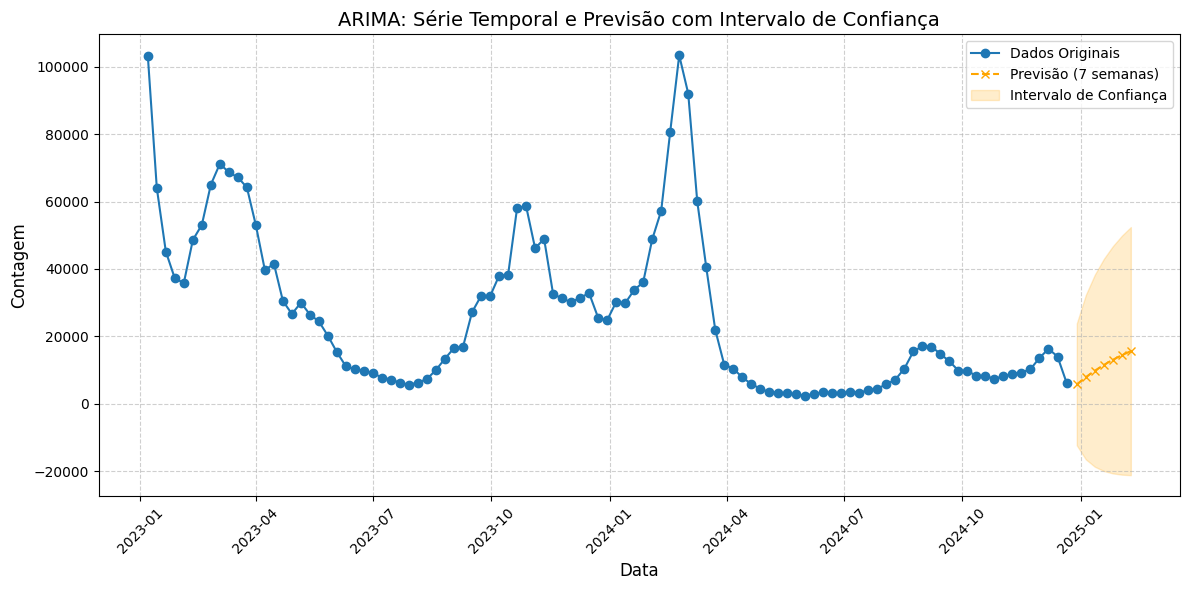

In [138]:
# Fazer previsões com intervalo de confiança
steps_ahead = 7
forecast_object = model.get_forecast(steps=steps_ahead)
forecast_mean = forecast_object.predicted_mean
confidence_intervals = forecast_object.conf_int()

# Preparar as datas para a previsão
forecast_dates = pd.date_range(start=serie_semana_analise.index[-1], periods=steps_ahead + 1, freq='W')[1:]

# Visualizar os resultados
plt.figure(figsize=(12, 6))

# Dados reais
plt.plot(serie_semana_analise.index, serie_semana_analise['count'], label='Dados Originais', marker='o')

# Previsão
plt.plot(forecast_dates, forecast_mean, label=f'Previsão ({steps_ahead} semanas)', color='orange', marker='x', linestyle='--')

# Intervalo de confiança
plt.fill_between(forecast_dates,
                 confidence_intervals.iloc[:, 0],  # Limite inferior
                 confidence_intervals.iloc[:, 1],  # Limite superior
                 color='orange', alpha=0.2, label='Intervalo de Confiança')

# Configurações do gráfico
plt.title('ARIMA: Série Temporal e Previsão com Intervalo de Confiança', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [ ]:
# Visualização dos dados
plt.figure(figsize=(10, 6))
plt.plot(serie_semana_analise['dt_event'], serie_semana_analise['count'], color='b')

plt.title('Casos leves de COVID-19 por semana epidemiológica.', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xlabel('Data (Último dia da semana)', fontsize=12)
plt.ylabel('Número de casos', fontsize=12)

plt.show()

# Validação do modelo

In [129]:
# Criar e ajustar o modelo ARIMA
arima_model = ARIMA(serie_semana_analise['count'][:80], order=(1, 1, 1))  # Configurar o modelo ARIMA com ordem (p,d,q)
model = arima_model.fit()

# Exibir o resumo do modelo
print(model.summary())

D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
D:\forecast_covid19\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   80
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -833.877
Date:                Thu, 02 Jan 2025   AIC                           1673.754
Time:                        17:18:55   BIC                           1680.862
Sample:                    01-07-2023   HQIC                          1676.602
                         - 07-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8922      0.032     28.323      0.000       0.830       0.954
ma.L1         -1.0000      0.110     -9.085      0.000      -1.216      -0.784
sigma2      8.456e+07    1.3e-09    6.5e+16      0.0

In [126]:
y_pred = pd.Series(model.forecast(22)[0], index=serie_semana_analise['count'][80:].index)
y_test = serie_semana_analise['count'][80:]

print(np.array(y_pred).astype(np.uint8))
print(np.array(y_test))

[99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]
[ 3995  4499  5749  7172 10428 15537 17049 16954 14776 12566  9834  9652
  8314  8135  7466  8121  8899  9262 10259 13603 16290 14014  6288]


C:\Users\pedro.sa\AppData\Local\Temp\ipykernel_18060\637461241.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = pd.Series(model.forecast(22)[0], index=serie_semana_analise['count'][80:].index)
